In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
batch_size = 128
epochs = 50
lr0 = 0.1

In [4]:
def linear_decay(epoch):
    epochs_drop = 20
    drop = 0.5
    lrate = lr0 * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(linear_decay)

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [6]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.1)

In [8]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization=True
)

test_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization=True
)

In [9]:
train_datagen.fit(x_train)
valid_datagen.fit(x_valid)
test_datagen.fit(x_test)

In [10]:
def fire_module(x, s1x1, e1x1, e3x3, name):
    #Squeeze layer
    squeeze = Conv2D(s1x1, (1, 1), activation='relu', padding='valid', kernel_initializer='glorot_uniform', name = name + 's1x1')(x)
    squeeze_bn = BatchNormalization(name=name+'sbn')(squeeze)
    
    #Expand 1x1 layer and 3x3 layer are parallel

    #Expand 1x1 layer
    expand1x1 = Conv2D(e1x1, (1, 1), activation='relu', padding='valid', kernel_initializer='glorot_uniform', name = name + 'e1x1')(squeeze_bn)
    
    #Expand 3x3 layer
    expand3x3 = Conv2D(e3x3, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform', name = name +  'e3x3')(squeeze_bn)
    
    #Concatenate expand1x1 and expand 3x3 at filters
    output = Concatenate(axis = 3, name=name)([expand1x1, expand3x3])
    
    return output

In [11]:
def SqueezeNet(height, width, channel):
    inputs = Input(shape=(height, width, channel))
    conv1 = Conv2D(96, kernel_size=(3, 3), strides=(2, 2),  padding='same', activation='relu', name = 'Conv1')(inputs)
    maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='Maxpool1')(conv1)
    batch1 = BatchNormalization(name='Batch1')(maxpool1)
    fire2 = fire_module(batch1, 16, 64, 64, "Fire2")
    fire3 = fire_module(fire2, 16, 64, 64, "Fire3")
    fire4 = fire_module(batch1, 32, 128, 128, "Fire4")
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='Maxpool2')(fire4)
    fire5 = fire_module(maxpool4, 32, 128, 128, "Fire5")
    fire6 = fire_module(maxpool4, 48, 192, 192, "Fire6")
    fire7 = fire_module(fire6, 48, 192, 192, "Fire7")
    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='Maxpool5')(fire7)
    fire8 = fire_module(fire7, 64, 256, 256, "Fire8")
    fire9 = fire_module(maxpool8, 64, 256, 256, "Fire9")
    dropout = Dropout(0.5, name="Dropout")(maxpool8)
    conv10 = Conv2D(10, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name='Conv6')(dropout)
    batch10 = BatchNormalization(name='Batch6')(conv10)
    avgpool10 = GlobalAveragePooling2D(name='GlobalAvgPool6')(batch10)
    softmax = Activation('softmax')(avgpool10)
    
    squeezenet = Model(inputs=inputs, outputs=softmax)
    return squeezenet

In [18]:
squeezenet = SqueezeNet(32, 32, 3)
sgd = SGD(lr = lr0, momentum = 0.9, nesterov=False)
squeezenet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [13]:
# squeezenet.summary()

In [14]:
callbacks_list = [lrate]
squeezenet_his = squeezenet.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size), 
                                    steps_per_epoch = len(x_train) / batch_size, 
                                    epochs = epochs, 
                                   validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=batch_size),
                                   validation_steps=len(x_valid) / batch_size,
                                          callbacks=callbacks_list)

2023-02-09 04:12:41.884344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-02-09 04:12:43.639751: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


351/351 [==============================] - 33s 72ms/step - loss: 1.6187 - accuracy: 0.4005 - val_loss: 1.8052 - val_accuracy: 0.4368
Epoch 2/50
351/351 [==============================] - 23s 65ms/step - loss: 1.2881 - accuracy: 0.5374 - val_loss: 1.3297 - val_accuracy: 0.5310
Epoch 3/50
351/351 [==============================] - 22s 63ms/step - loss: 1.1461 - accuracy: 0.5957 - val_loss: 1.0043 - val_accuracy: 0.6430
Epoch 4/50
351/351 [==============================] - 23s 64ms/step - loss: 1.0314 - accuracy: 0.6355 - val_loss: 1.0312 - val_accuracy: 0.6446
Epoch 5/50
351/351 [==============================] - 24s 69ms/step - loss: 0.9681 - accuracy: 0.6650 - val_loss: 0.9718 - val_accuracy: 0.6554
Epoch 6/50
351/351 [==============================] - 23s 66ms/step - loss: 0.9065 - accuracy: 0.6838 - val_loss: 0.8354 - val_accuracy: 0.7128
Epoch 7/50
351/351 [==============================] - 22s 64ms/step - loss: 0.8552 - accuracy: 0.7020 - val_loss: 0.7882 - val_accuracy: 0.7246
Epo

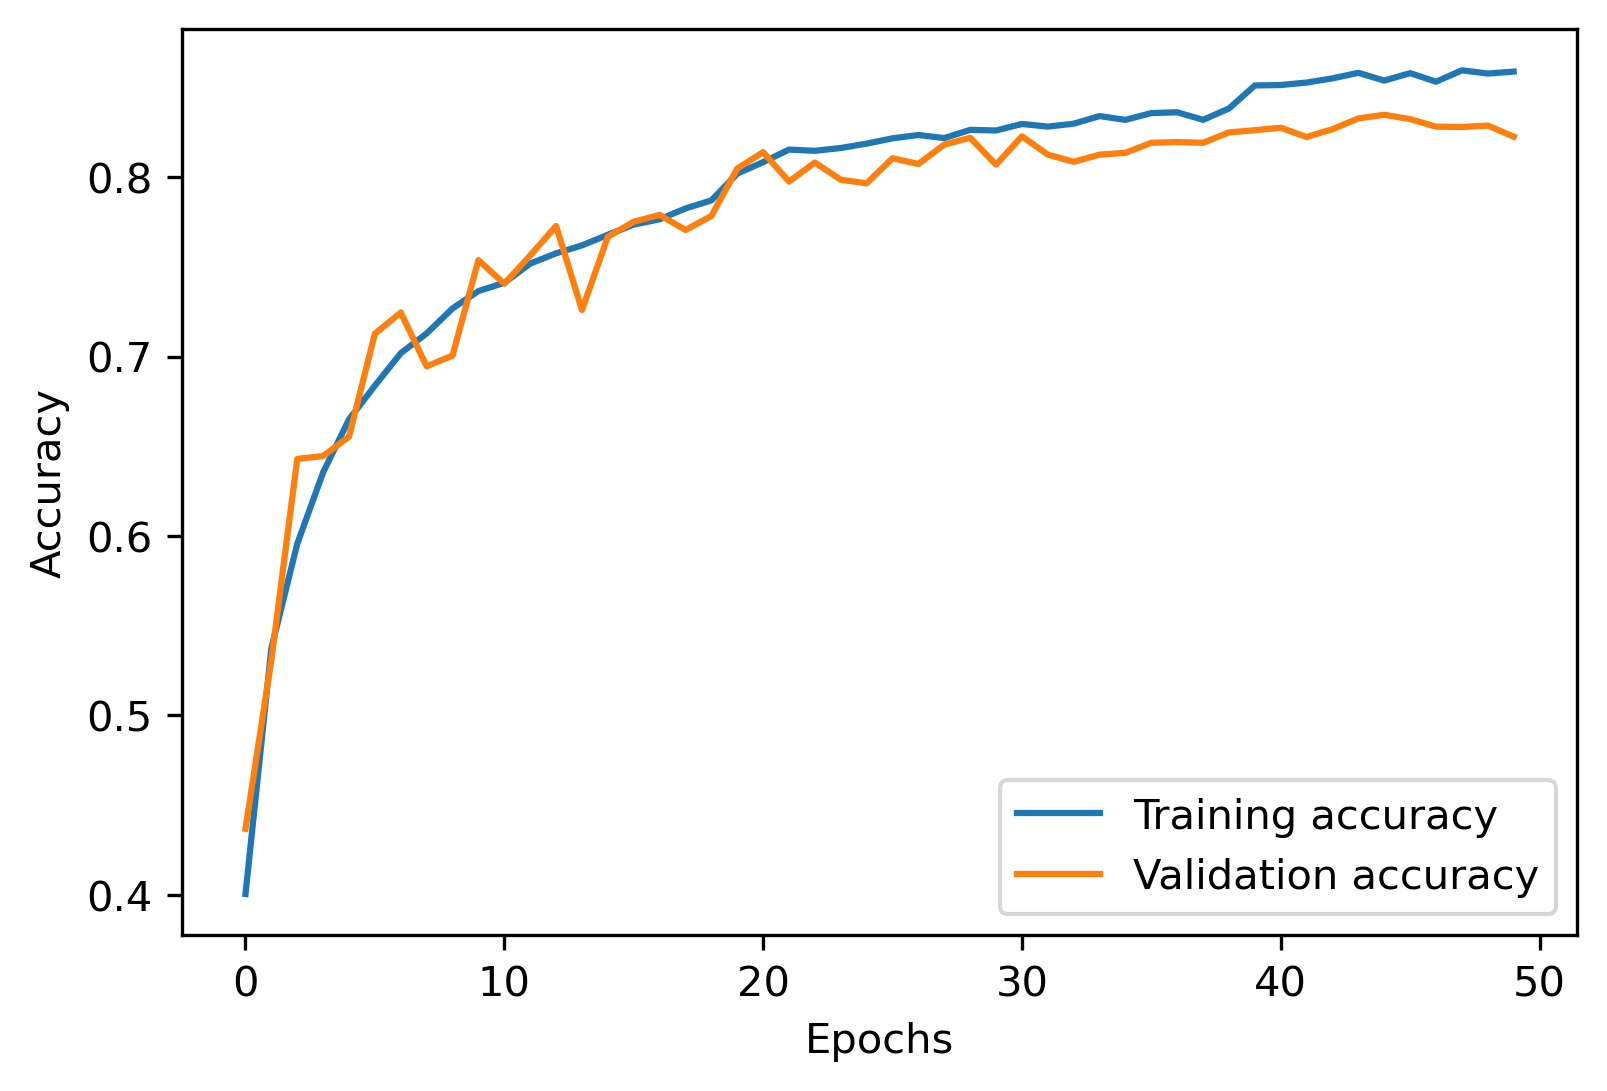

In [15]:
fig, ax = plt.subplots(1, 1)
# ax = ax.ravel()
ax.plot(squeezenet_his.history['accuracy'])
ax.plot(squeezenet_his.history['val_accuracy'])
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(["Training accuracy", "Validation accuracy"])
plt.savefig("Acc.png")

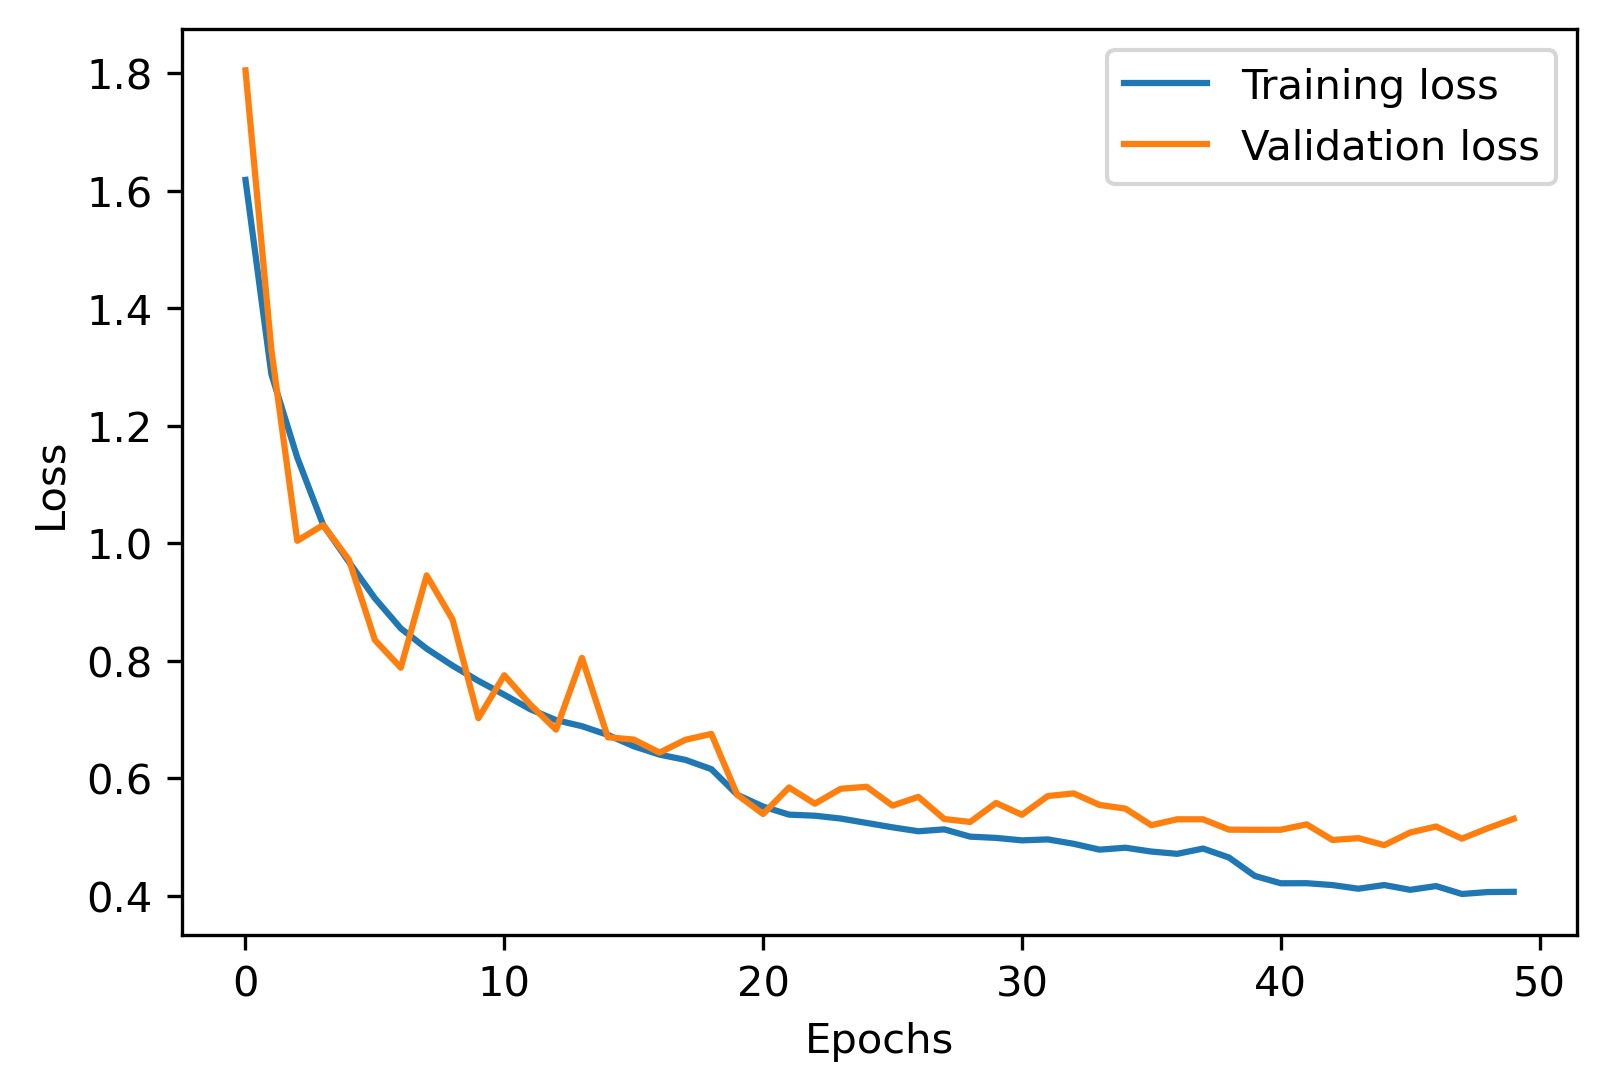

In [16]:
fig, ax = plt.subplots(1, 1)
# ax = ax.ravel()
ax.plot(squeezenet_his.history['loss'])
ax.plot(squeezenet_his.history['val_loss'])
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend(["Training loss", "Validation loss"])
plt.savefig("l.png")